In [1]:
import os
from pathlib import Path
from typing import Optional

import fastmri
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from data_utils import *
from datasets import *
from fastmri.data.transforms import tensor_to_complex_np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torch.utils.data import DataLoader, TensorDataset

from model import *
from torch.optim import SGD, Adam, AdamW
from train_utils import *

In [2]:
path_to_data = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'


In [3]:
n_volumes= 1
n_slices= 1
with_mask= True  # NOTE: During inference phase, set to True.
acceleration= 4
vol_embedding_dim = 256
coil_embedding_dim = 128
center_frac= 0.15
embedding_dim = 256
sigma = 0.1

dataset = KCoordDataset(path_to_data, n_volumes=n_volumes, n_slices=n_slices, with_mask=with_mask, acceleration=acceleration, center_frac=center_frac)



In [ ]:
dataloader = DataLoader(
    dataset,
    batch_size=1_000,
    num_workers=0,
    shuffle=True,
)

vol_id = 0
shape = dataloader.dataset.metadata[vol_id]["shape"]
center_data = dataloader.dataset.metadata[vol_id]["center"]
left_idx, right_idx, center_vals = (
    center_data["left_idx"],
    center_data["right_idx"],
    center_data["vals"],
)
n_slices, n_coils, height, width = shape

volume_kspace = torch.zeros(
    (n_slices, n_coils, height, width, 2),
    dtype=torch.float32,
)
predicted_volume = volume_kspace.clone()

for batch_idx, (inputs,inputs_unnormalized,targets) in enumerate(dataloader):
    
    coords = inputs[:, 1:-1] # kx,ky,kz
    vol_ids = inputs[:,0].long()
    coil_ids = inputs[:,-1].long() # unnormalized coilID
    
    predicted_volume[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = outputs
    volume_kspace[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = targets

(-0.5, 319.5, 319.5, -0.5)

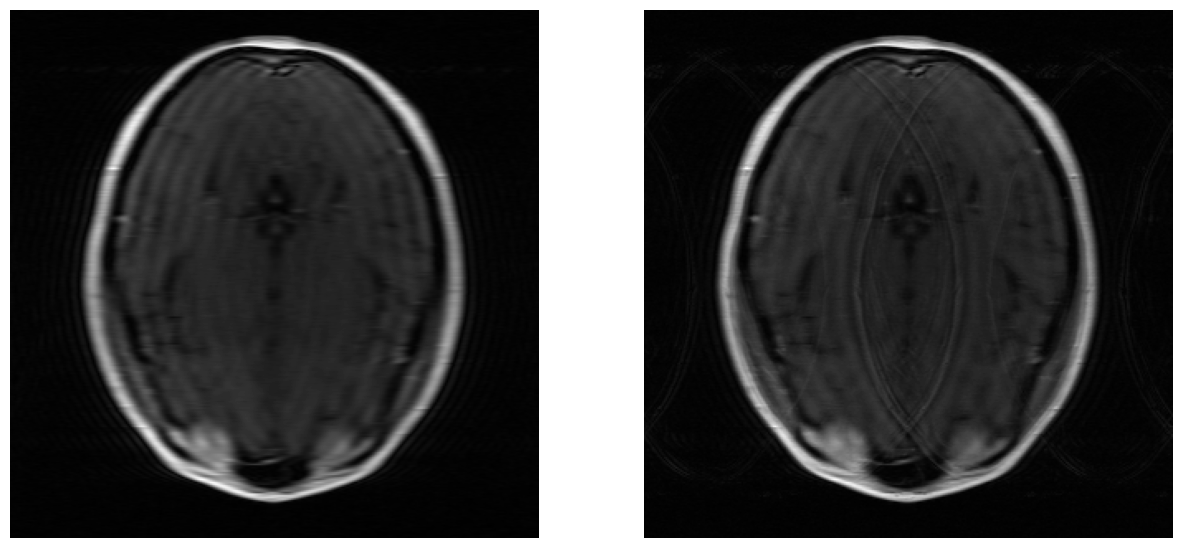

In [ ]:
gt_volume_kspace = (
    volume_kspace * dataloader.dataset.metadata[vol_id]["norm_cste"]
)

gt_volume_kspace = tensor_to_complex_np(gt_volume_kspace)

gt_volume_kspace[..., left_idx:right_idx] = center_vals

predicted_img = rss(inverse_fft2_shift(predicted_kspace))
gt_img = rss(inverse_fft2_shift(gt_volume_kspace))

eps = 1.e-45

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
# plt.imshow(np.log(np.abs(predicted_kspace[0]) + eps))
plt.imshow(np.abs(predicted_img[0]), cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.abs(gt_img[0]), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(np.log(np.abs(gt_kspace[0]) + eps))
plt.axis('off')



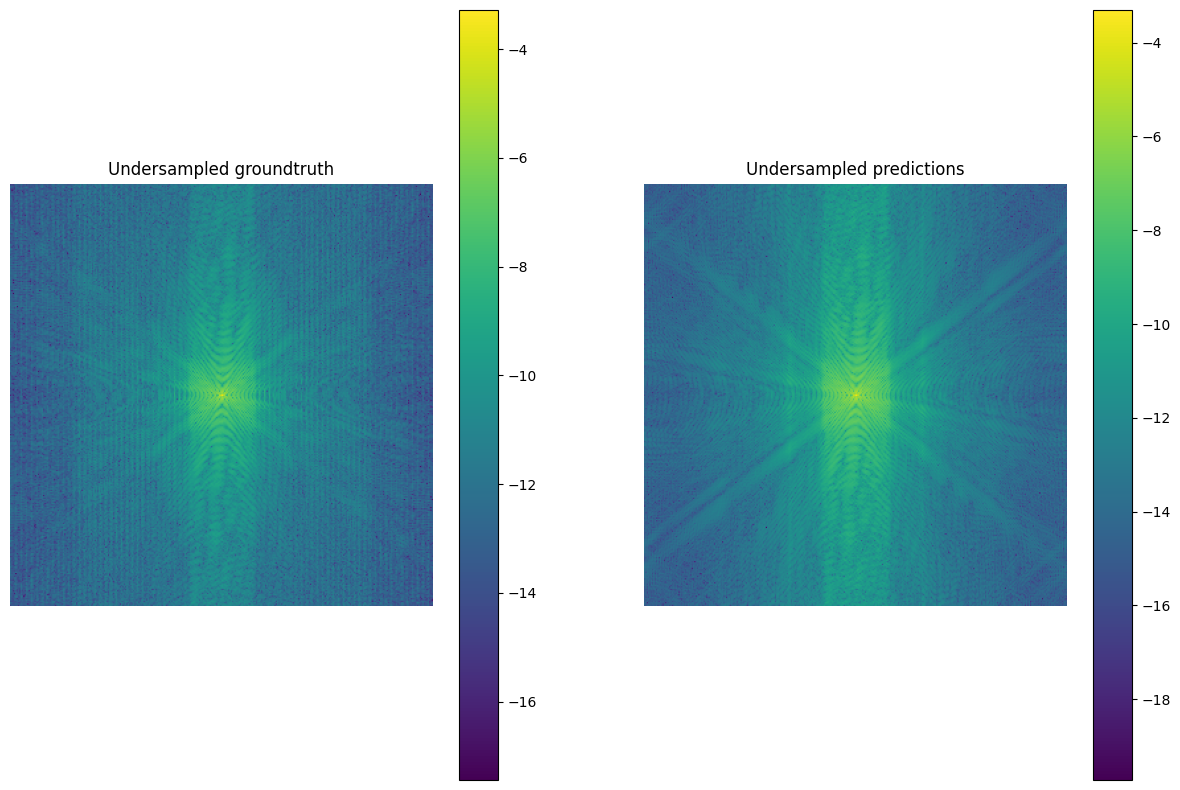

In [25]:
gt_modulus = np.abs(fft2_shift(gt_img))
predicted_modulus = np.abs(fft2_shift(predicted_img))


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np.log(gt_modulus[0] + eps))
plt.axis('off')
plt.title('Undersampled groundtruth')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.log(predicted_modulus[0] + eps))
plt.axis('off')
plt.title('Undersampled predictions')
plt.colorbar()

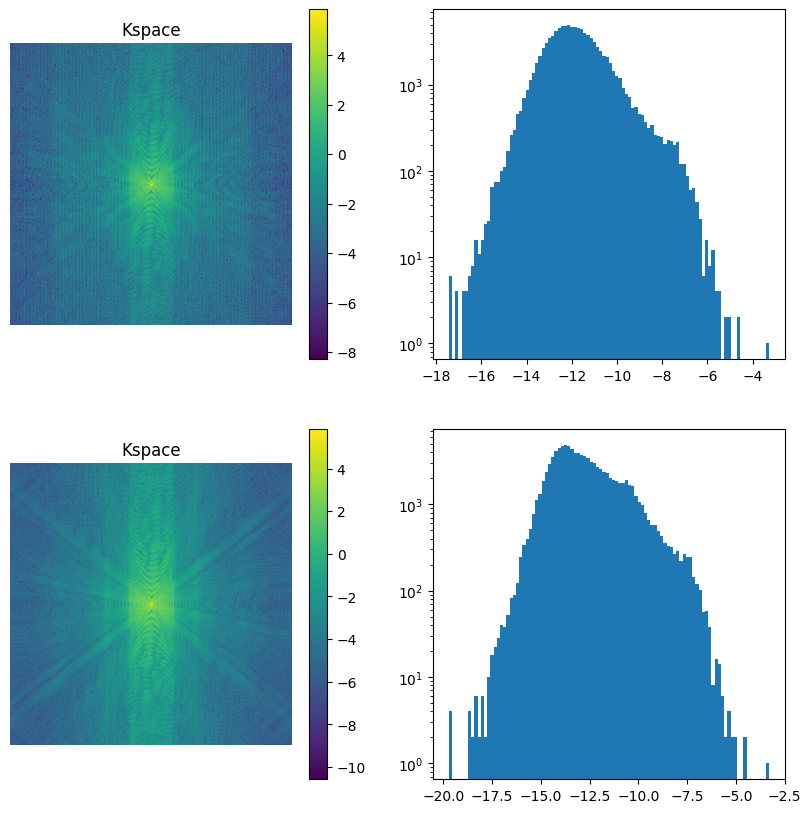

In [24]:
plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
plt.imshow(np.log(gt_modulus[0] / dataloader.dataset.metadata[vol_id]["norm_cste"] + eps))
plt.axis('off')
plt.colorbar()
plt.title("Kspace")
plt.subplot(2, 2, 2)
plt.hist(np.log(gt_modulus[0].flatten()), log=True, bins=100)
plt.subplot(2, 2, 3)
plt.imshow(np.log(predicted_modulus[0] / dataloader.dataset.metadata[vol_id]["norm_cste"] + eps))
plt.axis('off')
plt.colorbar()
plt.title("Kspace")
plt.subplot(2, 2, 4)
plt.hist(np.log(predicted_modulus[0].flatten()), log=True, bins=100)
plt.show()
